In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain

In [2]:
from scipy.stats import ttest_ind
import math
 
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

In [3]:
from scipy.stats import entropy
from collections import Counter

# functions to compute entropy 

def to_pmf(outcomes):
    ''' outcomes -> probability mass function '''
    cnts=Counter(outcomes)
    return np.asarray(list(cnts.values()))/sum(cnts.values())

def week2places(week):
    return list(chain(*[places for url, places in week]))

def places2ids(places):
    return [place['result'][0]['place_id'] for place in places]

def get_level_entropy(periods, level):
    return [entropy(to_pmf(places2ids(places2levels(week2places(week))[level]))) for date, week in periods.items()]

### LA Weekly

In [4]:
from locality import get_state, get_country, get_city, get_county

def place2level(place):    
    if get_country(place['result'][0]) != 'US':
        return 'international'
    elif get_state(place['result'][0]) != 'CA':
        return 'national'
    elif get_county(place['result'][0]) != 'Los Angeles County':
        return 'state'
    elif get_city(place['result'][0]) != 'Los Angeles':
        return 'county'
    else:
        return 'city'
    
def places2levels(places):
    levels = {'city':[], 'state':[], 'county':[], 'national':[], 'international':[]}
    for place in places:
        levels[place2level(place)].append(place)
    return levels

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
# load LAW data 
with open('../data/places/la/pre-weeks.p', 'rb') as f:
    pre_weeks_la = pickle.load(f)
with open('../data/places/la/post-weeks.p', 'rb') as f:
    post_weeks_la = pickle.load(f)
# load LAW data (pandemic cut out of data)
with open('../data/places/la/pre-weeks-cut.p', 'rb') as f:
    pre_weeks_la = pickle.load(f)
with open('../data/places/la/post-weeks-cut.p', 'rb') as f:
    post_weeks_la = pickle.load(f)

In [7]:
pre_ent = get_level_entropy(pre_weeks_la, 'city')
post_ent = get_level_entropy(post_weeks_la, 'city')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  2.0007712531125437 1.7694983247270761
p =  1.2177149909157597e-06
d =  0.7446916957436505


In [8]:
pre_ent = get_level_entropy(pre_weeks_la, 'county')
post_ent = get_level_entropy(post_weeks_la, 'county')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.331429123788766 2.8616725693361222
p =  2.6833126297077402e-20
d =  1.5501997377023495


In [9]:
pre_ent = get_level_entropy(pre_weeks_la, 'state')
post_ent = get_level_entropy(post_weeks_la, 'state')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.3112008884654767 2.9967594215711366
p =  1.2175770759689936e-08
d =  0.8854853662888852


In [10]:
pre_ent = get_level_entropy(pre_weeks_la, 'national')
post_ent = get_level_entropy(post_weeks_la, 'national')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.305327241097732 3.0623318212407766
p =  4.778646604791987e-08
d =  0.8452923525981363


In [11]:
pre_ent = get_level_entropy(pre_weeks_la, 'international')
post_ent = get_level_entropy(post_weeks_la, 'international')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.6409741628808296 3.2029497937865647
p =  3.634353177769013e-17
d =  1.3849552117131048


### NYD News

In [37]:
from locality import get_state, get_country, get_city
def place2level(place):    
    if get_country(place['result'][0]) != 'US':
        return 'international'
    elif get_state(place['result'][0]) != 'NY':
        return 'national'
    elif get_sublocality(place['result'][0]) not in ['Staten Island', 'Manhattan','Brooklyn','The Bronx', 'Queens'] \
        and get_city(place['result'][0]) != 'New York':
        return 'state'
    else:
        return 'city'
    
def get_sublocality(result):
    try:
        return [part['short_name'] for part in result['address_components'] 
                    if part['types'] == ['political', 'sublocality', 'sublocality_level_1']][0]
    except IndexError:
        return -1

In [23]:
# load NYD data
with open('../data/places/ny/pre-weeks.p', 'rb') as f:
    ny_pre_weeks = pickle.load(f)
# note that there are less post-weeks because of a suspicious trend in the data
with open('../data/places/ny/post-weeks.p', 'rb') as f:
    ny_post_weeks = pickle.load(f)

In [33]:
pre_ent = get_level_entropy(ny_pre_weeks, 'city')
post_ent = get_level_entropy(ny_post_weeks, 'city')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  2.7505274931504546 2.6164214183735264
p =  0.0011431258972135505
d =  0.7235798018935462


In [41]:
pre_ent = get_level_entropy(ny_pre_weeks, 'state')
post_ent = get_level_entropy(ny_post_weeks, 'state')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.005360481807581 2.7555375178782264
p =  2.043870752289193e-05
d =  0.9691855950728786


In [42]:
pre_ent = get_level_entropy(ny_pre_weeks, 'national')
post_ent = get_level_entropy(ny_post_weeks, 'national')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  4.225163448941176 4.190187350146722
p =  0.2921114750898629
d =  0.2279651889653511


In [43]:
pre_ent = get_level_entropy(ny_pre_weeks, 'international')
post_ent = get_level_entropy(ny_post_weeks, 'international')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.9332173072771868 3.794223233292792
p =  0.020751912941460844
d =  0.5065893342853787


### DFM

In [44]:
with open('../analysis/pub2loc.p', 'rb') as f:
    pub2loc = pickle.load(f)

In [65]:
# load DFM data
with open('../data/places/dfm/shared-weeks.p', 'rb') as f:
    s_weeks = pickle.load(f)
with open('../data/places/dfm/nonshared-weeks.p', 'rb') as f:
    ns_weeks = pickle.load(f)

In [66]:
def place2level(place, url):    
    if get_country(place['result'][0]) != 'US':
        return 'international'
    elif get_state(place['result'][0]) != 'CA':
        return 'national'
    elif get_county(place['result'][0]) != get_county(pub2loc[url.split('/')[2]]):
        return 'state'
    elif get_city(place['result'][0]) != get_city(pub2loc[url.split('/')[2]]):
        return 'county'
    else:
        return 'city'
    
def week2places(week):
    return list(chain(*[[[url, place] for place in places] for url, places in week]))

def places2levels(places):
    levels = {'city':[], 'state':[], 'county':[], 'national':[], 'international':[]}
    for url, place in places:
        levels[place2level(place, url)].append(place)
    return levels

def places2ids(places):
    return [place['result'][0]['place_id'] for place in places]
    
def get_level_entropy(periods, level):
    return [entropy(to_pmf(places2ids(places2levels(week2places(week))[level]))) for date, week in periods.items()]

In [67]:
pre_ent = get_level_entropy(s_weeks, 'city')
post_ent = get_level_entropy(ns_weeks, 'city')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  2.2683161527616877 2.8028381273443026
p =  2.1012977301002142e-11
d =  -1.4767016950608682


In [69]:
pre_ent = get_level_entropy(s_weeks, 'county')
post_ent = get_level_entropy(ns_weeks, 'county')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.5704240195265617 3.9837220824943933
p =  2.5819344236103666e-08
d =  -1.1836417756007849


In [70]:
pre_ent = get_level_entropy(s_weeks, 'state')
post_ent = get_level_entropy(ns_weeks, 'state')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.921719889034378 4.042494400187852
p =  0.11060910494614716
d =  -0.3156387642747657


In [71]:
pre_ent = get_level_entropy(s_weeks, 'national')
post_ent = get_level_entropy(ns_weeks, 'national')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.8766888728319766 3.4083527918383
p =  9.712958169973099e-11
d =  1.4153454245289816


In [72]:
pre_ent = get_level_entropy(s_weeks, 'international')
post_ent = get_level_entropy(ns_weeks, 'international')
print('Mean: ', np.mean(pre_ent), np.mean(post_ent))
print('p = ', ttest_ind(pre_ent, post_ent).pvalue)
print('d = ', cohend(pre_ent, post_ent))

Mean:  3.6955348860132307 3.1031543357917335
p =  1.7162453957350754e-08
d =  1.2011463667626334


## DP

In [8]:
with open('../data/places/dp/dp-weeks.p', 'rb') as f:
    weeks = pickle.load(f)
with open('../data/places/dp/dp-years.p', 'rb') as f:
    years = pickle.load(f)

In [9]:
len(weeks), len(years)

(626, 12)

In [10]:
from locality import (get_state, get_country, get_city, 
                      get_county, resolve, places2ids, 
                      places2coords, week2places, places2levels, 
                      places2ids, get_level_entropy, get_level_mass)

def place2level(place):    
    if get_country(place['result'][0]) != 'US':
        return 'international'
    elif get_state(place['result'][0]) != 'CO':
        return 'national'
    elif get_county(place['result'][0]) != 'Denver County':
        return 'state'
    elif get_city(place['result'][0]) != 'Denver':
        return 'county'
    else:
        return 'city'
levels = ['city','county', 'state', 'national', 'international']

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [11]:
entropy = {level:{year: dict(zip(weeks, get_level_entropy(weeks,level,place2level))) 
                          for year, weeks in years.items()} for level in levels}

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta

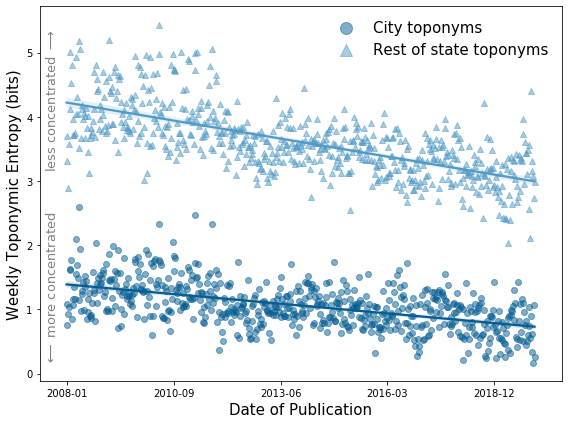

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

def to_list(entropy_vals):   
    ents = []
    for year, weeks in entropy_vals.items():
        for week, ent in weeks.items():
            ents.append([(week - datetime(2008,1,1)).days, ent])
    return ents

data = pd.DataFrame(to_list(entropy['city']), columns=['date', 'entropy'])
sns.regplot(x="date", y="entropy", 
            data=data, color=sns.color_palette('PuBu_r')[0], 
            ax=ax, label='City toponyms',
            scatter_kws={'alpha':0.5})

data = pd.DataFrame(to_list(entropy['state']), columns=['date', 'entropy'])
g = sns.regplot(x="date", y="entropy", data=data, ax=ax, 
                marker='^', color=sns.color_palette('PuBu_r')[2], label='Rest of state toponyms',scatter_kws={'alpha':0.5})

xs = g.get_xticks()
g.set_xticklabels([(datetime(2008,1,1) + timedelta(days=m)).strftime('%Y-%m') for m in xs])

#ax.set_xticks(range(len(data.date))) 
#ax.set_xticklabels([str(2008+m%52) if m%52 == 0 else '' for m in data.date])

ax.text(0.01, 0.75, 'less concentrated $\longrightarrow$',
        horizontalalignment='left',
        verticalalignment='center',
        rotation='vertical',
        transform=ax.transAxes,
        color='grey', size=13)

ax.text(0.01, 0.25, '$\longleftarrow$ more concentrated',
        horizontalalignment='left',
        verticalalignment='center',
        rotation='vertical',
        transform=ax.transAxes,
        color='grey', size=13)

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

ax.set_ylabel('Weekly Toponymic Entropy (bits)', size=15)
ax.set_xlabel('Date of Publication', size=15)
ax.legend(fontsize=15, markerscale=2, frameon=False)
fig.tight_layout()
plt.savefig('dp-toponymic-entropy-small.png', dpi=200)

In [14]:
levels = ['city','county', 'state', 'national', 'international']

In [15]:
def to_list(entropy_vals):   
    ents = []
    for year, weeks in entropy_vals.items():
        for week, ent in weeks.items():
            ents.append([((week - datetime(2008,1,1)).days)/7, ent])
    return ents

print('slope\t', 'intercept\t', 'r_value\t','p_value\t', 'std_err\t')
    
data = pd.DataFrame(to_list(entropy['city']), columns=['date', 'entropy'])
slope, intercept, r_value, p_value, std_err = stats.linregress(data.date,data.entropy)
print(f'{round(slope,5)}\t', f'{round(intercept,4)}\t', 
          f'{round(r_value**2,4)}\t',f'{round(p_value,4)}\t', f'{round(std_err,4)}\t')

data = pd.DataFrame(to_list(entropy['state']), columns=['date', 'entropy'])
slope, intercept, r_value, p_value, std_err = stats.linregress(data.date,data.entropy)
print(f'{round(slope,5)}\t', f'{round(intercept,4)}\t', 
          f'{round(r_value**2,4)}\t',f'{round(p_value,4)}\t', f'{round(std_err,4)}\t')
data = pd.DataFrame(to_list(entropy['national']), columns=['date', 'entropy'])
slope, intercept, r_value, p_value, std_err = stats.linregress(data.date,data.entropy)
print(f'{round(slope,5)}\t', f'{round(intercept,4)}\t', 
          f'{round(r_value**2,4)}\t',f'{round(p_value,4)}\t', f'{round(std_err,4)}\t')
    
data = pd.DataFrame(to_list(entropy['international']), columns=['date', 'entropy'])
slope, intercept, r_value, p_value, std_err = stats.linregress(data.date,data.entropy)
print(f'{round(slope,5)}\t', f'{round(intercept,4)}\t', 
          f'{round(r_value**2,4)}\t',f'{round(p_value,4)}\t', f'{round(std_err,4)}\t')

slope	 intercept	 r_value	 p_value	 std_err	
-0.00105	 1.3878	 0.2809	 0.0	 0.0001	
-0.00196	 4.2211	 0.4493	 0.0	 0.0001	
-0.00122	 4.5202	 0.4525	 0.0	 0.0001	
-0.0021	 4.5094	 0.5831	 0.0	 0.0001	
